# Permeability Simulation Using PoreSpy and OpenPNM
This simulation is based on the original notebook [Berea Sandstone Simulation Using PoreSpy and OpenPNM](https://github.com/PMEAL/OpenPNM/blob/master/examples/simulations/Berea%20Sandstone%20-%20Effective%20Permeability.ipynb)

### Start by importing the necessary packages

In [1]:
import imageio
import numpy as np
import porespy as ps
import openpnm as op
import scipy.ndimage as spim
import matplotlib.pyplot as plt
from porespy.filters import find_peaks, trim_saddle_points, trim_nearby_peaks
from porespy.tools import randomize_colors
from skimage.segmentation import watershed

ps.settings.tqdm['disable'] = True
ps.visualization.set_mpl_style()
np.random.seed(10)

### Load Sandstone Data

In [2]:
resolution = 2.25e-6
name = 'Bentheimer'

In [3]:
# Read input RAW file
raw_file = np.fromfile(name+'.raw', dtype=np.uint8)
im = (raw_file.reshape(1000,1000,1000))
im = im==0;
im=im[:400,:400,:400]

### Confirm image and check image porosity


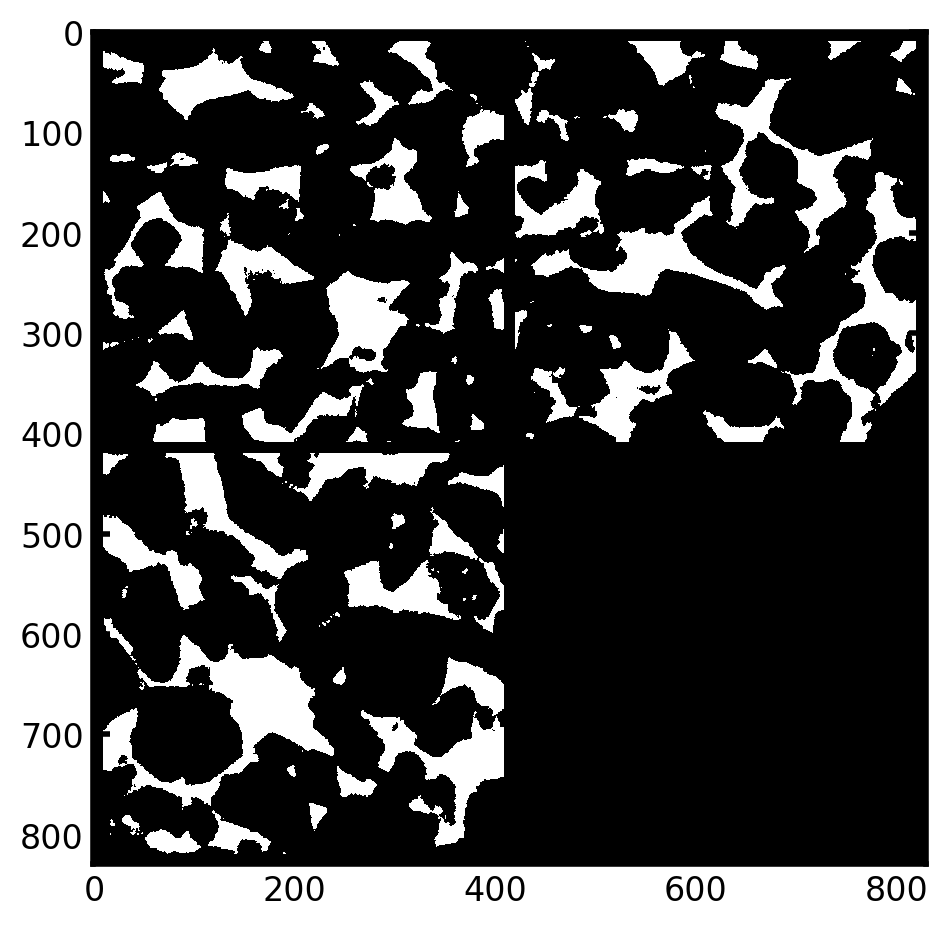

In [4]:
fig, ax = plt.subplots()
ax.imshow(ps.visualization.show_planes(im), cmap=plt.cm.bone);

In [5]:
sigma = 0.4
dt = spim.distance_transform_edt(input=im)
dt1 = spim.gaussian_filter(input=dt, sigma=sigma)
peaks = find_peaks(dt=dt)

### Import network in OpenPNM

In [6]:
print('Initial number of peaks: ', spim.label(peaks)[1])
peaks = trim_saddle_points(peaks=peaks, dt=dt1)
print('Peaks after trimming saddle points: ', spim.label(peaks)[1])
peaks = trim_nearby_peaks(peaks=peaks, dt=dt)
peaks, N = spim.label(peaks)
print('Peaks after trimming nearby peaks: ', N)

Initial number of peaks:  5655
Peaks after trimming saddle points:  3997
Peaks after trimming nearby peaks:  3403


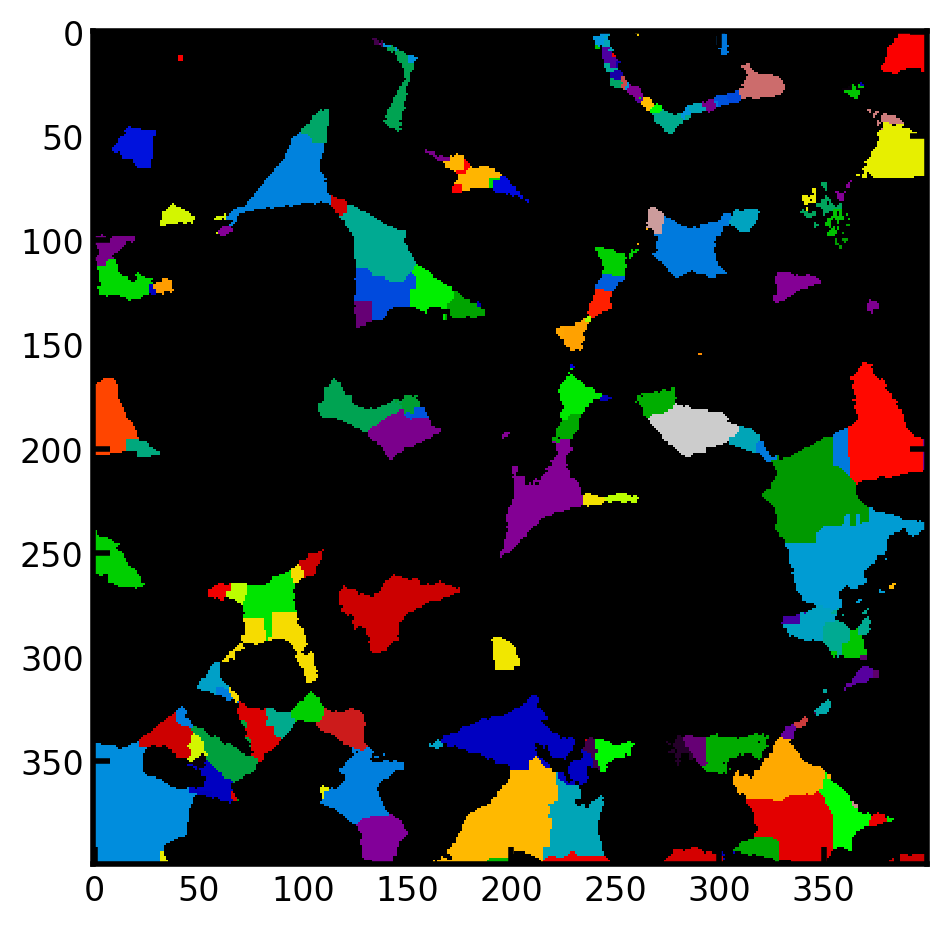

In [7]:
regions = watershed(image=-dt, markers=peaks, mask=dt > 0)
regions = randomize_colors(regions)
fig, ax = plt.subplots()
ax.imshow((regions*im)[:, :, 100], cmap=plt.cm.nipy_spectral);

## Optional: load already saved network

In [8]:
net = ps.networks.regions_to_network(regions*im, voxel_size=resolution,accuracy='high')

In [9]:
pn = op.io.network_from_porespy(net)
pn.add_model_collection(op.models.collections.geometry.cubes_and_cuboids)
pn.regenerate_models()
op.topotools.label_faces(pn, label='surface')
print(pn)


══════════════════════════════════════════════════════════════════════════════
net : <openpnm.network.Network at 0x2e5c4661900>
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Properties                                                   Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  2  throat.conns                                                  6708 / 6708
  3  pore.coords                                                   3403 / 3403
  4  pore.region_label                                             3403 / 3403
  5  pore.phase                                                    3403 / 3403
  6  throat.phases                                                 6708 / 6708
  7  pore.region_volume                                            3403 / 3403
  8  pore.equivalent_diameter                                      3403 / 3403
  9  pore.local_peak                                               3403 / 3403
 1

In [10]:
h = op.utils.check_network_health(pn)
op.topotools.trim(network=pn, pores=h['isolated_pores'])
# op.topotools.trim(network=pn, pores=h['disconnected_pores'])
print(h)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Key                                 Value
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
headless_throats                    []
looped_throats                      []
isolated_pores                      [188, 214, 221, 322, 600, 679, 727, 778, 779, 780, 997, 1020, 1081, 1099, 1158, 1239, 1348, 1473, 1906, 2242, 2479, 2579, 2599, 2777, 2804, 2816, 2819, 2862, 2918, 2942, 2969, 3051, 3108, 3156, 3264, 3292, 3363, 3398]
disconnected_pores                  [18, 40, 78, 81, 82, 87, 106, 110, 134, 145, 188, 197, 214, 221, 238, 264, 272, 278, 286, 309, 322, 363, 392, 491, 579, 581, 584, 585, 589, 600, 667, 672, 679, 700, 727, 742, 778, 779, 780, 803, 865, 992, 997, 1020, 1025, 1055, 1081, 1095, 1099, 1149, 1152, 1158, 1239, 1264, 1266, 1273, 1275, 1348, 1360, 1375, 1435, 1437, 1451, 1473, 1552, 1615, 1676, 1705, 1743, 1770, 1838, 1906, 1950, 1953, 1964, 2016, 2018, 2035, 2063, 2075, 

In [11]:
h = op.utils.check_network_health(pn)
# op.topotools.trim(network=pn, pores=h['isolated_pores'])
op.topotools.trim(network=pn, pores=h['disconnected_pores'])
print(h)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Key                                 Value
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
headless_throats                    []
looped_throats                      []
isolated_pores                      []
disconnected_pores                  [18, 40, 78, 81, 82, 87, 106, 110, 134, 145, 196, 235, 261, 269, 275, 283, 306, 359, 388, 487, 575, 577, 580, 581, 585, 662, 667, 694, 735, 793, 855, 982, 1013, 1043, 1082, 1135, 1138, 1248, 1250, 1257, 1259, 1343, 1358, 1418, 1420, 1434, 1534, 1597, 1658, 1687, 1725, 1752, 1820, 1931, 1934, 1945, 1997, 1999, 2016, 2044, 2056, 2126, 2127, 2128, 2200, 2228, 2279, 2310, 2322, 2364, 2389, 2399, 2517, 2601, 2704, 2728, 2737, 2754, 2815, 2820, 2851, 2864, 2878, 2928, 2972, 3017, 3040, 3102, 3113, 3157, 3170, 3260, 3342, 3350]
duplicate_throats                   []
bidirectional_throats               []
――――――――――――――――――――――――――――――――――――――――――

In [12]:
pn.add_model_collection(op.models.collections.geometry.spheres_and_cylinders)
pn.regenerate_models()
op.topotools.label_faces(pn, label='surface')

In [13]:
ax = op.visualization.plot_notebook(pn, node_color=pn['pore.volume'], node_scale=10)
ax.show()

In [14]:
pn.add_model(propname='pore.cluster_number',
             model=op.models.network.cluster_number)
pn.add_model(propname='pore.cluster_size',
             model=op.models.network.cluster_size)
print(pn)


══════════════════════════════════════════════════════════════════════════════
net : <openpnm.network.Network at 0x2e5c4661900>
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Properties                                                   Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  2  throat.conns                                                  6628 / 6628
  3  pore.coords                                                   3271 / 3271
  4  pore.region_label                                             3271 / 3271
  5  pore.phase                                                    3271 / 3271
  6  throat.phases                                                 6628 / 6628
  7  pore.region_volume                                            3271 / 3271
  8  pore.equivalent_diameter                                      3271 / 3271
  9  pore.local_peak                                               3271 / 3271
 1

In [18]:
im =ps.tools.align_image_with_openpnm(im)
imageio.volsave('image.tif', np.array(im, dtype=np.int8))
op.io.project_to_vtk(project=pn.project)

In [19]:

from vedo import *
import numpy as np

vol = Volume('image.tif')
show(vol, axes=1, viewup='z')

In [20]:
from vedo.applications import Slicer3DPlotter

In [21]:

vol1 = Volume('image.tif')


plt = Slicer3DPlotter(
    vol1,
    use_slider3d=False,
)
